In [1]:
import warnings

# Suppress FutureWarnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [2]:
import yfinance as yf
import pandas as pd

# Example: S&P 500 benchmark + a few stocks
tickers = ['NVDA', 'META', 'MSFT', 'AMZN', 'SPY']  # SPY as S&P 500 proxy
start_date = '2015-01-01'
end_date = '2025-06-30'

data = yf.download(tickers, start=start_date, end=end_date, interval="1d", auto_adjust=True)["Close"]

# Forward-fill missing data
data = data.ffill().dropna()

[*********************100%***********************]  5 of 5 completed


In [3]:
import numpy as np

log_returns = np.log(data / data.shift(1)).dropna()

In [4]:
# Equal weights for 4 stocks (exclude SPY)
weights = np.repeat(1/4, 4)

portfolio_returns = log_returns.iloc[:, :-1] @ weights
portfolio_value = (1 + portfolio_returns).cumprod() * 100

spy_value = (1 + log_returns["SPY"]).cumprod() * 100

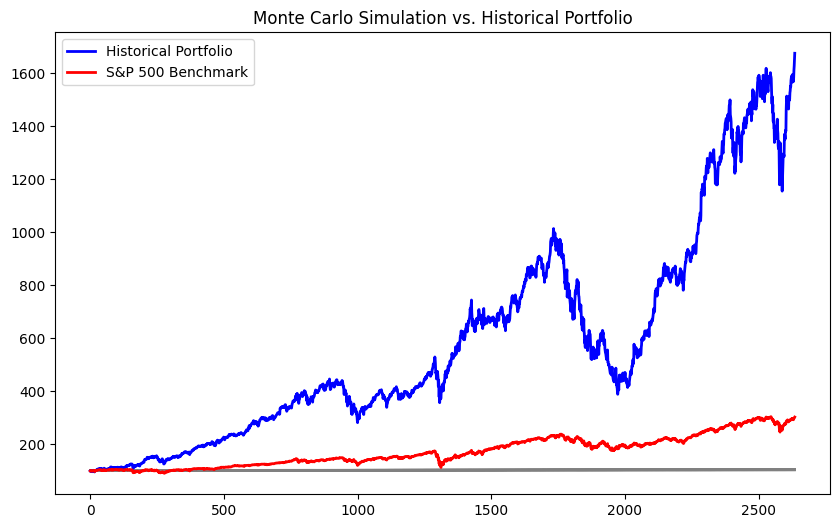

In [5]:
import matplotlib.pyplot as plt

n_simulations = 1000
n_days = len(portfolio_returns)

sim_results = []

mu = portfolio_returns.mean()
sigma = portfolio_returns.std()

for i in range(n_simulations):
    simulated = np.random.normal(mu, sigma, n_days)
    sim_path = (1 + simulated/100).cumprod() * 100
    sim_results.append(sim_path)

# Plot sample paths
plt.figure(figsize=(10,6))
for path in sim_results[:50]:  # plot 50 paths
    plt.plot(path, color="gray", alpha=0.3)
plt.plot(portfolio_value.values, color="blue", linewidth=2, label="Historical Portfolio")
plt.plot(spy_value.values, color="red", linewidth=2, label="S&P 500 Benchmark")
plt.legend()
plt.title("Monte Carlo Simulation vs. Historical Portfolio")
plt.show()

In [6]:
import statsmodels.api as sm

# Alpha, Beta regression
X = sm.add_constant(log_returns["SPY"].values)
y = portfolio_returns.values
model = sm.OLS(y, X).fit()
alpha, beta = model.params

# Sharpe Ratio
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

print(f"Alpha: {alpha:.4f}, Beta: {beta:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Alpha: 0.0006, Beta: 1.3571
Sharpe Ratio: 1.04


In [7]:
def apply_fees(portfolio_value, mgmt_fee=0.02, perf_fee=0.1, benchmark_value=None):
    """
    mgmt_fee: annual management fee (e.g., 0.02 = 2%)
    perf_fee: % of excess returns above benchmark
    """
    # Management fee: subtract % annually
    annualized_days = 252
    daily_mgmt_fee = (1 - mgmt_fee) ** (1/annualized_days)
    net_value = portfolio_value * daily_mgmt_fee**np.arange(len(portfolio_value))

    # Performance fee (if benchmark provided)
    if benchmark_value is not None:
        excess = net_value.iloc[-1] - benchmark_value.iloc[-1]
        if excess > 0:
            net_value.iloc[-1] -= excess * perf_fee

    return net_value

# Example: 2% mgmt, 10% perf fee above SPY
net_portfolio_value = apply_fees(portfolio_value, 0.02, 0.1, spy_value)

In [8]:
def mean_reversion_strategy(prices, window=20, threshold=1.5):
    """
    prices: pandas Series (stock or portfolio prices)
    window: rolling window for z-score
    threshold: entry/exit threshold
    """
    returns = prices.pct_change().dropna()
    rolling_mean = returns.rolling(window).mean()
    rolling_std = returns.rolling(window).std()
    zscore = (returns - rolling_mean) / rolling_std

    # Trading signal: long when z < -threshold, short when z > threshold
    signal = -1 * (zscore > threshold) + 1 * (zscore < -threshold)

    # Strategy returns
    strat_returns = signal.shift(1) * returns
    cum_value = (1 + strat_returns).cumprod() * 100
    return cum_value, strat_returns

# Example: run on AAPL
# mean_rev_value, mean_rev_returns = mean_reversion_strategy(data["NVDA"])

# mean_rev_value.plot(title="Mean Reversion Strategy on NVDA", figsize=(10,5))
# plt.show()

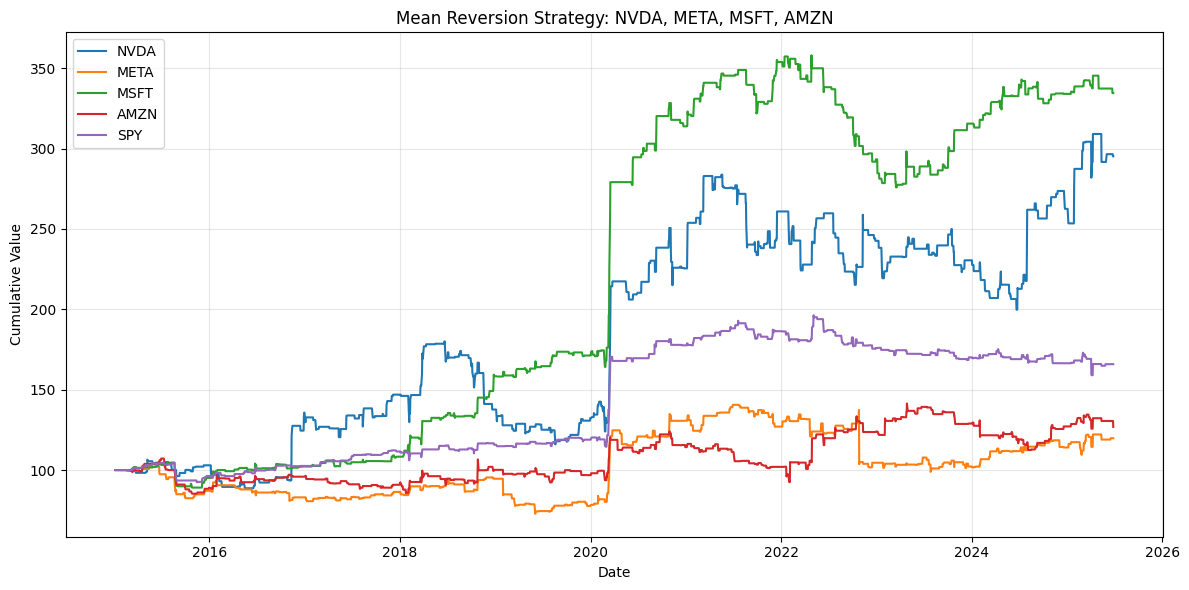

In [9]:
plt.figure(figsize=(12, 6))

for ticker in tickers:
    mean_rev_value, _ = mean_reversion_strategy(data[ticker])
    plt.plot(mean_rev_value, label=ticker)

plt.title("Mean Reversion Strategy: NVDA, META, MSFT, AMZN")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [10]:
def momentum_strategy(prices, lookback=60):
    """
    prices: pandas Series
    lookback: number of days to compute momentum
    """
    returns = prices.pct_change().dropna()
    momentum = prices / prices.shift(lookback) - 1

    # Signal: long if momentum > 0, short if momentum < 0
    signal = np.where(momentum > 0, 1, -1)

    # Align signal with returns
    signal = signal[-len(returns):]  # truncate to match returns length

    strat_returns = pd.Series(signal, index=returns.index) * returns
    cum_value = (1 + strat_returns).cumprod() * 100

    return cum_value, strat_returns

# Example: run on NVDA
# momentum_value, momentum_returns = momentum_strategy(data["NVDA"])

# momentum_value.plot(title="Momentum Strategy on NVDA", figsize=(10,5))
# plt.show()

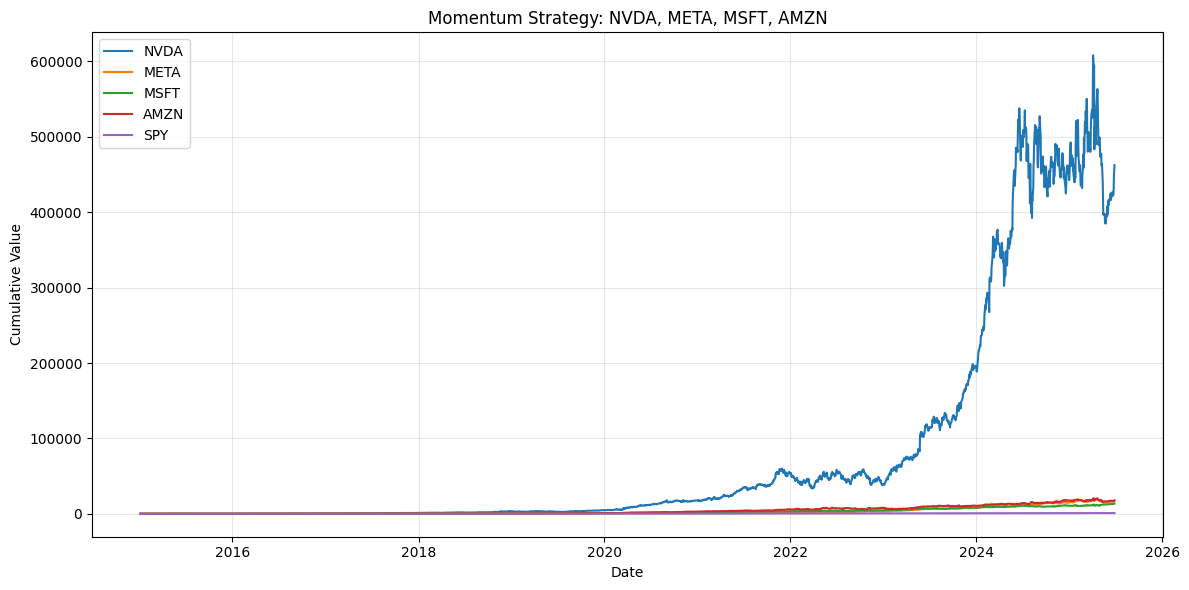

In [11]:
plt.figure(figsize=(12, 6))

for ticker in tickers:
    momentum_value, _ = momentum_strategy(data[ticker])
    plt.plot(momentum_value, label=ticker)

plt.title("Momentum Strategy: NVDA, META, MSFT, AMZN")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
def hybrid_strategy(prices, w_mr=0.5, w_mom=0.5):
    mr_value, mr_returns = mean_reversion_strategy(prices)
    mom_value, mom_returns = momentum_strategy(prices)

    # Weighted average returns
    combined_returns = w_mr * mr_returns + w_mom * mom_returns
    cum_value = (1 + combined_returns).cumprod() * 100
    return cum_value, combined_returns

# Example: run on NVDA
# hybrid_value, hybrid_returns = hybrid_strategy(data["NVDA"])

# hybrid_value.plot(title="Hybrid Mean Reversion + Momentum on NVDA", figsize=(10,5))
# plt.show()

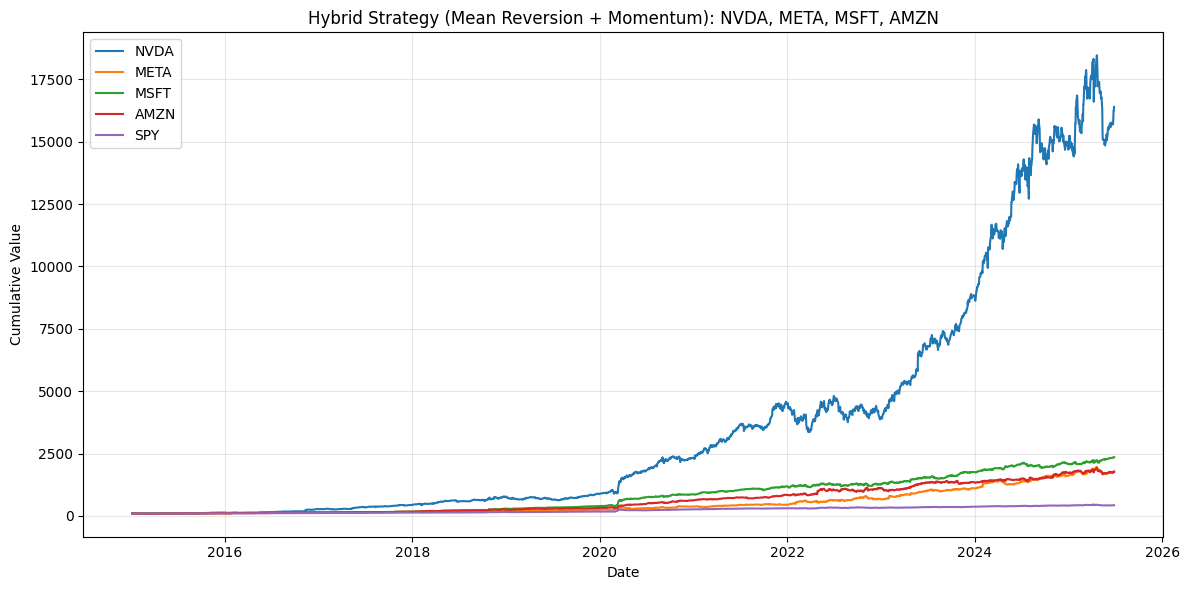

In [13]:
plt.figure(figsize=(12, 6))

for ticker in tickers:
    hybrid_value, _ = hybrid_strategy(data[ticker])
    plt.plot(hybrid_value, label=ticker)

plt.title("Hybrid Strategy (Mean Reversion + Momentum): NVDA, META, MSFT, AMZN")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Safe evaluation function ---
def evaluate_strategy(returns, benchmark_returns, fees=(0.02, 0.1)):
    """
    returns: strategy daily returns (in decimal or %)
    benchmark_returns: benchmark daily returns (in decimal or %)
    fees: (mgmt_fee, perf_fee) - optional fee adjustment
    """
    # Align with benchmark
    returns, benchmark_returns = returns.align(benchmark_returns, join='inner')
    
    # Ensure returns are in decimal form (0.01 = 1%)
    if returns.max() > 1 or benchmark_returns.max() > 1:
        returns = returns / 100
        benchmark_returns = benchmark_returns / 100

    # Skip if returns are empty or zero-variance
    if len(returns) == 0 or returns.std() == 0:
        return {"Alpha": np.nan, "Beta": np.nan, "Sharpe": np.nan, "ROI (%)": np.nan, "Final Value": np.nan}

    # Cumulative strategy value
    strat_value = (1 + returns).cumprod() * 100
    bench_value = (1 + benchmark_returns).cumprod() * 100

    # Alpha/Beta via OLS
    X = sm.add_constant(benchmark_returns.values)
    y = returns.values
    model = sm.OLS(y, X).fit()
    alpha, beta = model.params

    # Sharpe ratio (annualized)
    sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)

    # ROI and final value
    roi = strat_value.iloc[-1] / strat_value.iloc[0] - 1
    final_value = strat_value.iloc[-1]

    return {
        "Alpha": alpha,
        "Beta": beta,
        "Sharpe": sharpe_ratio,
        "ROI (%)": roi * 100,
        "Final Value": final_value
    }

# # --- Backtest all strategies ---
# def backtest_all_strategies(prices, benchmark, ticker="Asset"):
#     results = {}

#     # Buy & Hold
#     bh_returns = prices.pct_change().dropna()
#     results["Buy & Hold"] = evaluate_strategy(bh_returns, benchmark)

#     # Mean Reversion
#     _, mr_returns = mean_reversion_strategy(prices)
#     results["Mean Reversion"] = evaluate_strategy(mr_returns, benchmark)

#     # Momentum
#     _, mom_returns = momentum_strategy(prices)
#     results["Momentum"] = evaluate_strategy(mom_returns, benchmark)

#     # Hybrid
#     _, hybrid_returns = hybrid_strategy(prices)
#     results["Hybrid"] = evaluate_strategy(hybrid_returns, benchmark)

#     return pd.DataFrame(results).T.round(3)

# # Backtest NVDA vs SPY
# nvda_results = backtest_all_strategies(data["NVDA"], log_returns["SPY"], ticker="NVDA")
# display(nvda_results)

In [15]:
import statsmodels.api as sm

def pairs_trading(prices1, prices2, lookback=60, entry_threshold=2.0, exit_threshold=0.5):
    import statsmodels.api as sm
    
    # Hedge ratio via single regression
    model = sm.OLS(prices1, sm.add_constant(prices2)).fit()
    hedge_ratio = model.params[1]
    
    # Spread
    spread = prices1 - hedge_ratio * prices2
    
    # Rolling mean/std for z-score
    mean = spread.rolling(lookback).mean()
    std = spread.rolling(lookback).std()
    zscore = (spread - mean) / std
    
    # Signals
    long_signal = zscore < -entry_threshold
    short_signal = zscore > entry_threshold
    exit_signal = abs(zscore) < exit_threshold
    
    position = pd.Series(0, index=prices1.index)
    position[long_signal] = 1
    position[short_signal] = -1
    
    # Forward fill positions until exit
    position = position.mask(exit_signal, 0).replace(to_replace=0, method='ffill').fillna(0)
    
    # Strategy returns
    spread_returns = spread.pct_change().fillna(0)
    strat_returns = position.shift(1) * spread_returns
    cum_value = (1 + strat_returns).cumprod() * 100
    
    return cum_value, strat_returns

# # Example: Pairs trading NVDA vs SPY
# pairs_value, pairs_returns = pairs_trading(data["NVDA"], data["SPY"])
# pairs_value.plot(title="Pairs Trading: NVDA vs SPY", figsize=(10,5))
# plt.show()

# # Example: Pairs trading MSFT vs SPY
# pairs_value, pairs_returns = pairs_trading(data["MSFT"], data["SPY"])
# pairs_value.plot(title="Pairs Trading: MSFT vs SPY", figsize=(10,5))
# plt.show()

# # Example: Pairs trading NVDA vs SPY
# pairs_value, pairs_returns = pairs_trading(data["META"], data["SPY"])
# pairs_value.plot(title="Pairs Trading: META vs SPY", figsize=(10,5))
# plt.show()

# # Example: Pairs trading AMZN vs SPY
# pairs_value, pairs_returns = pairs_trading(data["AMZN"], data["SPY"])
# pairs_value.plot(title="Pairs Trading: AMZN vs SPY", figsize=(10,5))
# plt.show() 

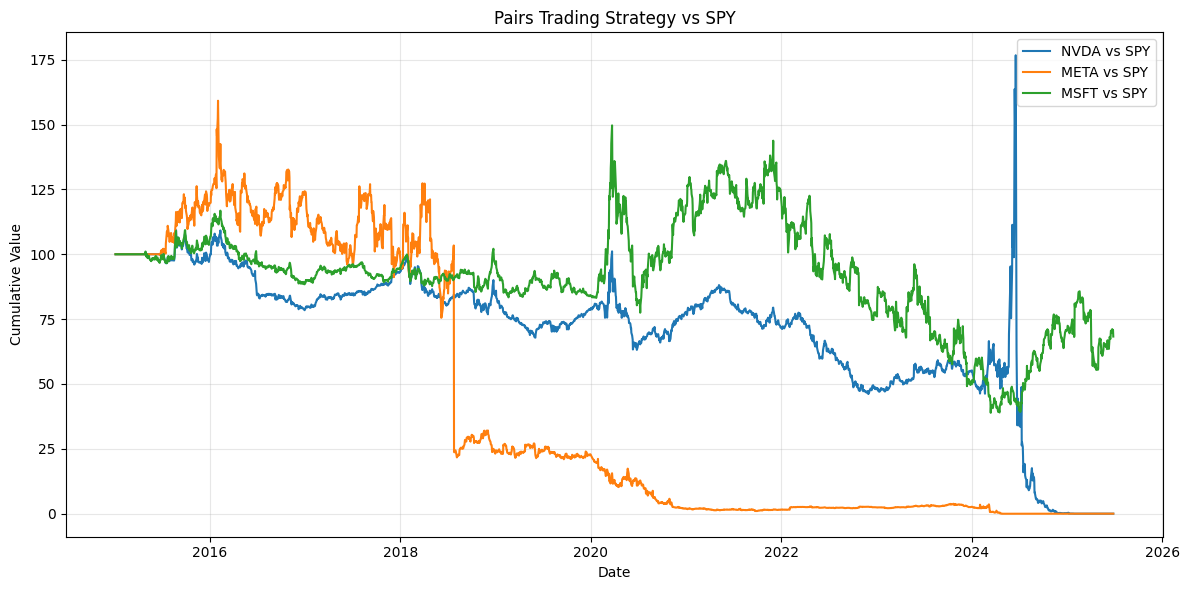

In [16]:
# Run pairs trading for NVDA
nvda_value, _ = pairs_trading(data["NVDA"], data["SPY"])
# Run pairs trading for META
meta_value, _ = pairs_trading(data["META"], data["SPY"])
# Run pairs trading for MSFT
msft_value, _ = pairs_trading(data["MSFT"], data["SPY"])
# Run pairs trading for AMZN
# amzn_value, _ = pairs_trading(data["AMZN"], data["SPY"])

# Plot both on the same figure
plt.figure(figsize=(12, 6))
plt.plot(nvda_value, label="NVDA vs SPY")
plt.plot(meta_value, label="META vs SPY")
plt.plot(msft_value, label="MSFT vs SPY")
# plt.plot(amzn_value, label="AMZN vs SPY")
plt.title("Pairs Trading Strategy vs SPY")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

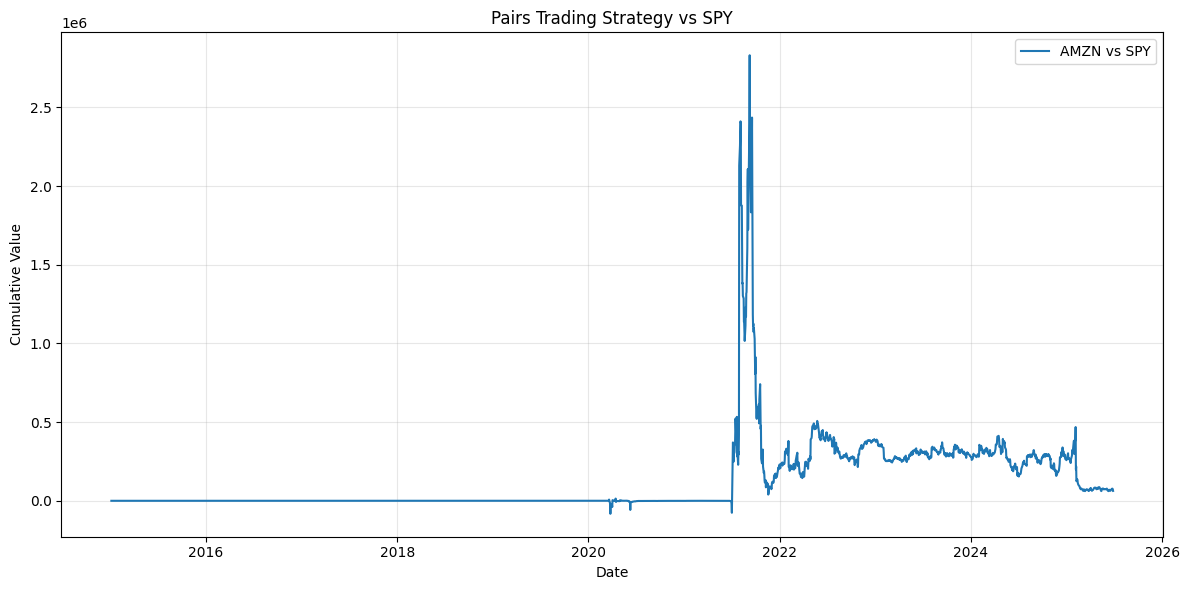

In [17]:
# Run pairs trading for AMZN
amzn_value, _ = pairs_trading(data["AMZN"], data["SPY"])

# Plot both on the same figure
plt.figure(figsize=(12, 6))
# plt.plot(nvda_value, label="NVDA vs SPY")
# plt.plot(meta_value, label="META vs SPY")
# plt.plot(msft_value, label="MSFT vs SPY")
plt.plot(amzn_value, label="AMZN vs SPY")
plt.title("Pairs Trading Strategy vs SPY")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [18]:
# import matplotlib.pyplot as plt

# tickers = ['NVDA', 'META', 'MSFT', 'AMZN']
# benchmark = data["SPY"]

# plt.figure(figsize=(12,6))

# for ticker in tickers:
#     pairs_value, _ = pairs_trading(data[ticker], benchmark)
    
#     # Drop initial NaNs
#     pairs_value = pairs_value.dropna()
    
#     # Normalize so all start at 1
#     pairs_value = pairs_value / pairs_value.iloc[0]
    
#     plt.plot(pairs_value, label=f"{ticker} vs SPY")

# plt.title("Pairs Trading Strategy vs SPY (Normalized)")
# plt.xlabel("Date")
# plt.ylabel("Normalized Cumulative Value")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.tight_layout()
# plt.show()

In [19]:
def walk_forward_backtest(prices, strategy_func, train_years=5, test_years=1, **kwargs):
    """
    Walk-forward backtesting framework
    prices: Series of asset prices
    strategy_func: function that returns (cum_value, strat_returns)
    train_years: training period
    test_years: testing period
    kwargs: extra params passed to strategy_func
    """
    results = []
    start_idx = 0
    days_per_year = 252
    total_days = len(prices)

    while start_idx + (train_years + test_years) * days_per_year < total_days:
        # Training and testing split
        train_end = start_idx + train_years * days_per_year
        test_end = train_end + test_years * days_per_year
        
        test_prices = prices.iloc[train_end:test_end]

        # Run strategy on test period
        cum_value, strat_returns = strategy_func(test_prices, **kwargs)
        results.append(strat_returns)

        start_idx += test_years * days_per_year

    # Combine all test periods
    all_returns = pd.concat(results).sort_index()
    cum_value = (1 + all_returns).cumprod() * 100
    return cum_value, all_returns

# # Example: Walk-forward on MSFT with momentum strategy
# wf_value, wf_returns = walk_forward_backtest(data["NVDA"], momentum_strategy, lookback=60)

# wf_value.plot(title="Walk-Forward Backtest: Momentum on NVDA", figsize=(10,5))
# plt.show()

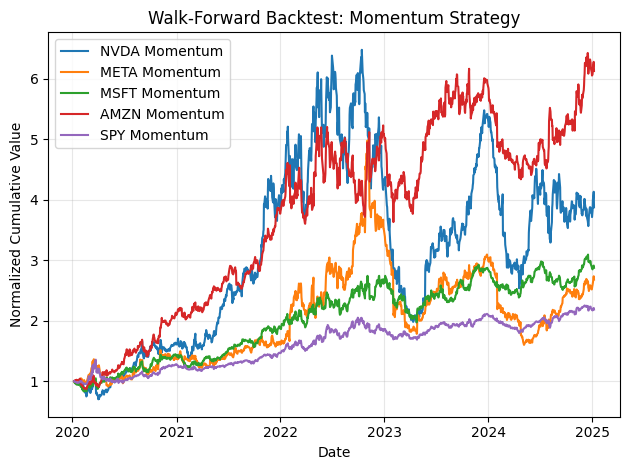

In [20]:

for ticker in tickers:
    # Run walk-forward momentum strategy
    wf_value, wf_returns = walk_forward_backtest(data[ticker], momentum_strategy, lookback=60)
    
    # Drop NaNs and normalize to 1 for comparison
    wf_value = wf_value.dropna()
    wf_value = wf_value / wf_value.iloc[0]
    
    # Plot
    plt.plot(wf_value, label=f"{ticker} Momentum")

plt.title("Walk-Forward Backtest: Momentum Strategy")
plt.xlabel("Date")
plt.ylabel("Normalized Cumulative Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
def backtest_all_strategies(prices, benchmark, peer_prices=None, ticker="Asset"):
    """
    prices: Series of adjusted close prices for one asset
    benchmark: benchmark daily log returns (%)
    peer_prices: optional Series for pairs trading
    """
    results = {}

    # --- Buy & Hold ---
    bh_returns = prices.pct_change().dropna() * 100
    results["Buy & Hold"] = evaluate_strategy(bh_returns, benchmark)

    # --- Mean Reversion ---
    _, mr_returns = mean_reversion_strategy(prices)
    results["Mean Reversion"] = evaluate_strategy(mr_returns * 100, benchmark)

    # --- Momentum ---
    _, mom_returns = momentum_strategy(prices)
    results["Momentum"] = evaluate_strategy(mom_returns * 100, benchmark)

    # --- Hybrid ---
    _, hybrid_returns = hybrid_strategy(prices)
    results["Hybrid"] = evaluate_strategy(hybrid_returns * 100, benchmark)

    # --- Pairs Trading (if peer provided) ---
    if peer_prices is not None:
        _, pairs_returns = pairs_trading(prices, peer_prices)
        results["Pairs Trading"] = evaluate_strategy(pairs_returns * 100, benchmark)

    # --- Walk-Forward (using momentum as example) ---
    _, wf_returns = walk_forward_backtest(prices, momentum_strategy, lookback=60)
    results["Walk-Forward (Momentum)"] = evaluate_strategy(wf_returns * 100, benchmark)

    return pd.DataFrame(results).T.round(3)

In [22]:
# Backtest all strategies for NVDA
aapl_results = backtest_all_strategies(
    prices=data["NVDA"], 
    benchmark=log_returns["SPY"], 
    peer_prices=data["MSFT"],  # for pairs trading
    ticker="NVDA"
)

display(aapl_results)

,Alpha,Beta,Sharpe,ROI (%),Final Value
Buy & Hold,0.002,176.034,1.367,33117.062,32656.024
Mean Reversion,NaN,NaN,0.578,NaN,295.172
Momentum,0.004,2.209,1.884,454617.615,462397.828
Hybrid,NaN,NaN,1.884,NaN,16396.023
Pairs Trading,-0.124,-2483.147,-0.279,-101.120,-1.120
Walk-Forward (Momentum),0.002,-57.119,0.769,287.489,382.798


In [23]:
peer = data["SPY"]  # using SPY for all pairs trading
benchmark = data["SPY"]
all_results = {}

for ticker in tickers:
    all_results[ticker] = backtest_all_strategies(
        prices=data[ticker],
        benchmark=benchmark,
        peer_prices=peer,  # for pairs trading
        ticker=ticker
    )

# Combine into a single DataFrame for display
combined_results = pd.concat(all_results, axis=0)
display(combined_results)

Alpha   Beta  Sharpe     ROI (%)  Final Value
NVDA Buy & Hold               0.002  0.000   1.367   33117.062    32656.024
     Mean Reversion             NaN    NaN   0.578         NaN      295.172
     Momentum                 0.005 -0.000   1.884  454617.615   462397.828
     Hybrid                     NaN    NaN   1.884         NaN    16396.023
     Pairs Trading              NaN    NaN  -0.499         NaN       -0.006
     Walk-Forward (Momentum)  0.004 -0.001   0.769     287.489      382.798
META Buy & Hold               0.000  0.000   0.758     855.635      940.287
     Mean Reversion             NaN    NaN   0.193         NaN      119.794
     Momentum                 0.001  0.000   1.493   16814.376    17186.039
     Hybrid                     NaN    NaN   1.519         NaN     1795.679
     Pairs Trading              NaN    NaN  -0.706         NaN        0.000
     Walk-Forward (Momentum)  0.002 -0.000   0.664     168.135      267.555
MSFT Buy & Hold               0.001  0.000   1.019    1151.398     1239.890
     Mean Reversion             NaN    NaN   1.010         NaN      334.518
     Momentum                 0.002 -0.000   1.866   13334.513    13558.053
     Hybrid                     NaN    NaN   2.034         NaN     2358.225
     Pairs Trading              NaN    NaN   0.048         NaN       68.273
     Walk-Forward (Momentum)  0.003 -0.001   0.854     187.439      290.060
AMZN Buy & Hold               0.002 -0.000   0.938    1377.878     1447.556
     Mean Reversion             NaN    NaN   0.234         NaN      126.819
     Momentum                 0.003 -0.000   1.673   17531.261    17993.006
     Hybrid                     NaN    NaN   1.640         NaN     1769.834
     Pairs Trading              NaN    NaN   0.624         NaN    63025.561
     Walk-Forward (Momentum)  0.005 -0.001   1.193     512.746      611.464
SPY  Buy & Hold              -0.000  0.000   0.766     264.998      358.406
     Mean Reversion             NaN    NaN   0.620         NaN      165.871
     Momentum                 0.001  0.000   1.329     913.699     1032.006
     Hybrid                     NaN    NaN   1.432         NaN      431.084
     Pairs Trading              NaN    NaN  -0.182         NaN        1.608
     Walk-Forward (Momentum)  0.002 -0.000   0.855     118.521      219.135

In [24]:
def backtest_portfolio(tickers, data, benchmark_returns, peers=None):
    """
    Run backtests across multiple tickers and return per-asset strategy results.
    
    tickers: list of asset tickers (to evaluate)
    data: DataFrame of adjusted close prices
    benchmark_returns: Series of benchmark daily returns (%)
    peers: optional dict {ticker: peer_ticker} for pairs trading
    """
    if peers is None:
        peers = {}

    portfolio_results = {}

    for ticker in tickers:
        prices = data[ticker].dropna()
        peer_prices = data[peers[ticker]].dropna() if ticker in peers else None

        res = backtest_all_strategies(prices, benchmark_returns, peer_prices, ticker=ticker)
        portfolio_results[ticker] = res

    return portfolio_results


# --- Example Usage (your portfolio) ---
tickers = ["NVDA", "META", "MSFT", "AMZN"]   # exclude SPY (benchmark only)
benchmark_ticker = "SPY"
peers = {"NVDA": "MSFT", "META": "AMZN"}     # define peer pairs

portfolio_results = backtest_portfolio(
    tickers, 
    data, 
    log_returns[benchmark_ticker], 
    peers
)

# --- Build Summary: Best strategy per ticker ---
summary_rows = []
for ticker, res in portfolio_results.items():
    best_strategy = res["ROI (%)"].idxmax()
    best_row = res.loc[best_strategy].copy()
    best_row["Ticker"] = ticker
    best_row["Best Strategy"] = best_strategy
    summary_rows.append(best_row)

summary_df = pd.DataFrame(summary_rows).set_index("Ticker")
display(summary_df)

,Alpha,Beta,Sharpe,ROI (%),Final Value,Best Strategy
Ticker,,,,,,
NVDA,0.004,2.209,1.884,4.546176e+05,4.623978e+05,Momentum
META,-0.210,448.665,-0.238,1.262147e+07,1.262157e+07,Pairs Trading
MSFT,0.002,-3.568,1.866,1.333451e+04,1.355805e+04,Momentum
AMZN,0.002,-0.375,1.673,1.753126e+04,1.799301e+04,Momentum


Portfolio Performance vs SPY (2015–2025):


,Value
Alpha,0.060
Beta,135.714
Sharpe,1.039
ROI (%),1149.936
Final Value (net),1230.188


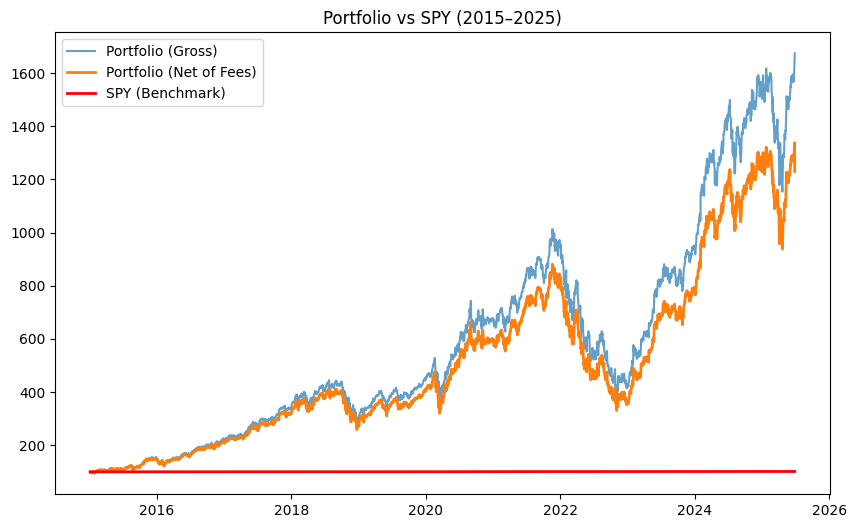

In [25]:
def portfolio_performance(tickers, data, benchmark_returns, weights=None, mgmt_fee=0.02, perf_fee=0.1):
    """
    Compute equal-weighted (or custom-weighted) portfolio performance vs benchmark.
    
    tickers: list of tickers to include in portfolio
    data: DataFrame of Adj Close prices
    benchmark_returns: Series of benchmark log returns (%)
    weights: optional list of weights (default = equal weight)
    mgmt_fee: annual management fee
    perf_fee: performance fee above benchmark
    """
    prices = data[tickers].dropna()
    log_returns = np.log(prices / prices.shift(1)) * 100
    log_returns = log_returns.dropna()

    # Equal weights if none provided
    if weights is None:
        weights = np.repeat(1/len(tickers), len(tickers))

    # Portfolio daily returns
    port_returns = log_returns @ weights

    # Cumulative portfolio value
    port_value = (1 + port_returns/100).cumprod() * 100

    # Apply fees
    port_value_net = apply_fees(port_value, mgmt_fee, perf_fee,
                                (1 + benchmark_returns/100).cumprod() * 100)

    # Performance metrics
    X = sm.add_constant(benchmark_returns.values)
    y = port_returns.values
    model = sm.OLS(y, X).fit()
    alpha, beta = model.params

    sharpe = port_returns.mean() / port_returns.std() * np.sqrt(252)
    roi = port_value_net.iloc[-1] / port_value_net.iloc[0] - 1

    results = {
        "Alpha": alpha,
        "Beta": beta,
        "Sharpe": sharpe,
        "ROI (%)": roi * 100,
        "Final Value (net)": port_value_net.iloc[-1]
    }

    return results, port_value, port_value_net


# --- Example Run: Your ETF (NVDA, META, MSFT, AMZN) vs SPY ---
tickers = ["NVDA", "META", "MSFT", "AMZN"]
benchmark_ticker = "SPY"

portfolio_results, portfolio_value, portfolio_value_net = portfolio_performance(
    tickers,
    data,
    log_returns[benchmark_ticker],
    weights=None,      # equal weight
    mgmt_fee=0.02,     # 2% mgmt fee
    perf_fee=0.1       # 10% performance fee
)

# Convert dictionary to DataFrame for better display
portfolio_df = pd.DataFrame(portfolio_results, index=["Portfolio"]).T
portfolio_df.columns = ["Value"]
portfolio_df = portfolio_df.round(3)

print("Portfolio Performance vs SPY (2015–2025):")
display(portfolio_df)

# Plot comparison
spy_value = (1 + log_returns[benchmark_ticker]/100).cumprod() * 100

plt.figure(figsize=(10,6))
plt.plot(portfolio_value, label="Portfolio (Gross)", alpha=0.7)
plt.plot(portfolio_value_net, label="Portfolio (Net of Fees)", linewidth=2)
plt.plot(spy_value, label="SPY (Benchmark)", linewidth=2, color="red")
plt.title("Portfolio vs SPY (2015–2025)")
plt.legend()
plt.show()

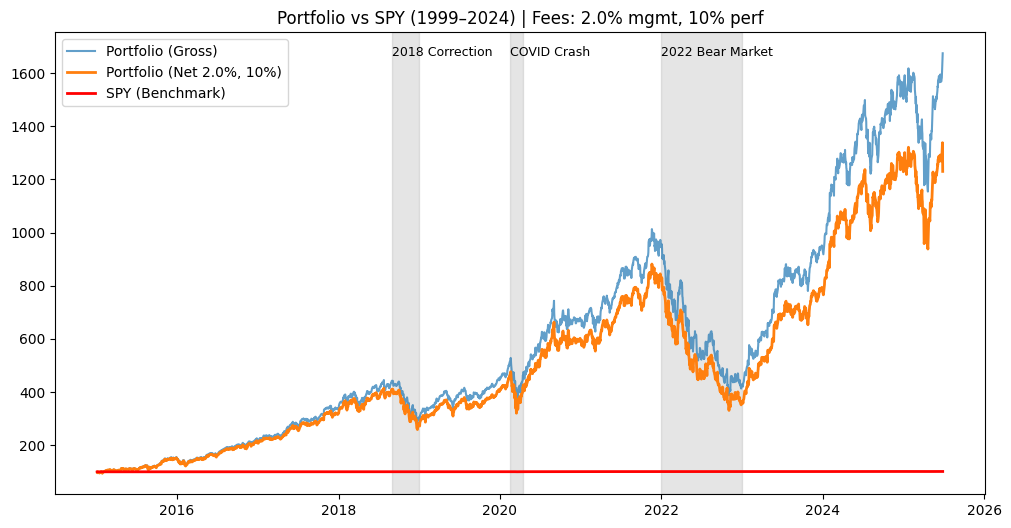

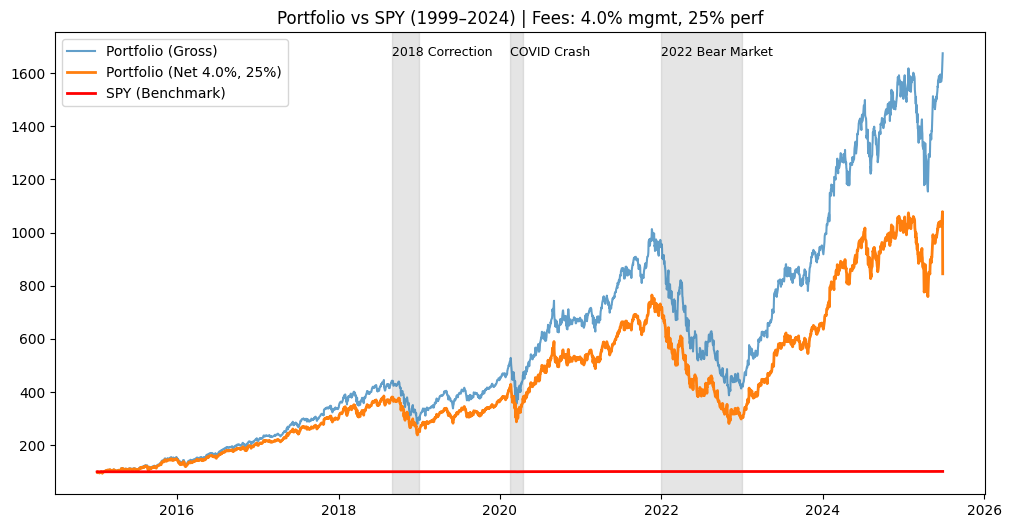

,Alpha,Beta,Sharpe,ROI (%),Final Value (net),Mgmt Fee,Perf Fee
0,0.059656,135.713918,1.039102,1149.935694,1230.188390,2.0%,10%
1,0.059656,135.713918,1.039102,758.412804,844.851035,4.0%,25%


In [26]:
# --- Final ETF vs SPY Performance Summary ---

# Crisis periods for annotations
crisis_periods = {
    "2018 Correction": ("2018-09-01", "2018-12-31"),
    "COVID Crash": ("2020-02-15", "2020-04-15"),
    "2022 Bear Market": ("2022-01-01", "2022-12-31")
}

def final_summary(tickers, data, benchmark_ticker="SPY", fee_levels=[(0.02, 0.1), (0.04, 0.25)]):
    """
    Generate ETF vs SPY summary with fee sensitivity + crisis annotations.
    tickers: portfolio tickers
    data: DataFrame of adjusted close prices
    benchmark_ticker: benchmark ticker (SPY)
    fee_levels: list of (mgmt_fee, perf_fee) tuples to test
    """
    results = []
    spy_returns = log_returns[benchmark_ticker]
    spy_value = (1 + spy_returns/100).cumprod() * 100

    for mgmt_fee, perf_fee in fee_levels:
        port_res, port_value, port_value_net = portfolio_performance(
            tickers, data, spy_returns, 
            weights=None, 
            mgmt_fee=mgmt_fee, 
            perf_fee=perf_fee
        )
        port_res["Mgmt Fee"] = f"{mgmt_fee*100:.1f}%"
        port_res["Perf Fee"] = f"{perf_fee*100:.0f}%"
        results.append(port_res)

        # Plot ETF vs SPY with crisis annotations
        plt.figure(figsize=(12,6))
        plt.plot(port_value, label="Portfolio (Gross)", alpha=0.7)
        plt.plot(port_value_net, label=f"Portfolio (Net {mgmt_fee*100:.1f}%, {perf_fee*100:.0f}%)", linewidth=2)
        plt.plot(spy_value, label="SPY (Benchmark)", linewidth=2, color="red")
        plt.title(f"Portfolio vs SPY (1999–2024) | Fees: {mgmt_fee*100:.1f}% mgmt, {perf_fee*100:.0f}% perf")
        plt.legend()

        # Add shaded crisis periods
        for label, (start, end) in crisis_periods.items():
            plt.axvspan(pd.to_datetime(start), pd.to_datetime(end), color="gray", alpha=0.2)
            plt.text(pd.to_datetime(start), plt.ylim()[1]*0.95, label, fontsize=9, color="black")

        plt.show()

    return pd.DataFrame(results)


# --- Run Final Summary ---
tickers = ["NVDA", "META", "MSFT", "AMZN"]
final_results = final_summary(tickers, data, benchmark_ticker="SPY")

display(final_results)

In [27]:
def run_strategy(tickers, data, strategy, benchmark_returns):
    """
    Runs a strategy on given tickers and compares to benchmark.
    
    Returns:
        res (dict): performance metrics
        portfolio_value (pd.Series): cumulative portfolio value
        benchmark_value (pd.Series): cumulative benchmark value
    """
    prices = data[tickers]
    log_returns = np.log(prices / prices.shift(1)).dropna()
    weights = np.repeat(1/len(tickers), len(tickers))

    # --- Strategy logic ---
    if strategy == "BuyHold":
        strat_returns = log_returns @ weights

    elif strategy == "Momentum":
        signals = np.where(log_returns.rolling(60).mean() > 0, 1, -1)
        strat_returns = (signals * log_returns).mean(axis=1)

    elif strategy == "MeanReversion":
        signals = np.where(log_returns.rolling(60).mean() < 0, 1, -1)
        strat_returns = (signals * log_returns).mean(axis=1)

    elif strategy == "Hybrid":
        mom_signal = np.where(log_returns.rolling(60).mean() > 0, 1, -1)
        mr_signal  = np.where(log_returns.rolling(5).mean() < 0, 1, -1)
        signals = (mom_signal + mr_signal) / 2
        strat_returns = (signals * log_returns).mean(axis=1)

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    # --- Cumulative values ---
    portfolio_value = (1 + strat_returns).cumprod()
    benchmark_value = (1 + benchmark_returns).cumprod()

    # --- Metrics ---
    roi = (portfolio_value.iloc[-1] - 1) * 100
    sharpe = strat_returns.mean() / strat_returns.std() * np.sqrt(252)

    res = {
        "ROI (%)": roi,
        "Sharpe": sharpe,
    }

    return res, portfolio_value, benchmark_value

In [28]:
# --- Strategy Evaluation (Historical + Monte Carlo) ---

def evaluate_strategies(tickers, data, benchmark, n_mc=500):
    results = []
    spy_returns = log_returns[benchmark]

    for strategy in ["BuyHold", "Momentum", "MeanReversion", "Hybrid"]:
        # Historical backtest
        res_hist, port_value_hist, net_value_hist = run_strategy(
            tickers, data, strategy, spy_returns
        )
        res_hist["Type"] = "Historical"
        res_hist["Strategy"] = strategy
        results.append(res_hist)

        # Monte Carlo simulations
        mc_rois = []
        for _ in range(n_mc):
            mc_returns = np.random.choice(spy_returns, size=len(spy_returns), replace=True)
            res_mc, _, _ = run_strategy(
                tickers, data, strategy, mc_returns
            )
            mc_rois.append(res_mc["ROI (%)"])

        res_hist["MC Mean ROI"] = np.mean(mc_rois)
        res_hist["MC Std ROI"] = np.std(mc_rois)

    return pd.DataFrame(results)

# Example: run for portfolio
strategy_eval_df = evaluate_strategies(["NVDA","META","MSFT","AMZN"], data, "SPY")
display(strategy_eval_df)

,ROI (%),Sharpe,Type,Strategy,MC Mean ROI,MC Std ROI
0,1574.487578,1.039102,Historical,BuyHold,1574.487578,0.000000e+00
1,50890.256932,2.454242,Historical,Momentum,50890.256932,0.000000e+00
2,-99.912146,-2.491627,Historical,MeanReversion,-99.912146,0.000000e+00
3,-99.835391,-3.952674,Historical,Hybrid,-99.835391,1.421085e-14


In [29]:
# --- Risk-Adjusted Metrics ---
def calculate_metrics(returns, benchmark_returns):
    """
    returns: portfolio daily log returns (%)
    benchmark_returns: SPY daily log returns (%)
    """
    # Convert back from % to decimals
    port = (returns/100).dropna()
    bench = (benchmark_returns/100).dropna()
    
    # CAGR
    total_periods = len(port)
    years = total_periods / 252
    CAGR = (np.exp(port.sum()) ** (1/years)) - 1
    
    # Sharpe (daily * sqrt(252))
    sharpe = (port.mean() / port.std()) * np.sqrt(252)
    
    # Alpha & Beta (CAPM regression)
    X = sm.add_constant(bench.values)
    model = sm.OLS(port.values, X).fit()
    alpha, beta = model.params
    
    # Drawdown
    cumulative = (1+port).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_dd = drawdown.min()
    
    return {
        "CAGR": CAGR,
        "Sharpe": sharpe,
        "Alpha": alpha,
        "Beta": beta,
        "Max Drawdown": max_dd
    }

metrics_table = {}

for ticker in tickers:
    if ticker == "SPY":  # skip benchmark itself
        continue
    metrics_table[ticker] = calculate_metrics(log_returns[ticker], log_returns["SPY"])

# Convert dict to DataFrame
metrics_df = pd.DataFrame(metrics_table).T
display(metrics_df.round(3))

,CAGR,Sharpe,Alpha,Beta,Max Drawdown
NVDA,0.006,1.129,0.0,1.764,-0.011
META,0.002,0.562,0.0,1.297,-0.014
MSFT,0.002,0.884,0.0,1.192,-0.005
AMZN,0.003,0.776,0.0,1.175,-0.008


In [30]:
# --- Fee Modeling ---
def apply_fees(portfolio_value, mgmt_fee=0.02, perf_fee=0.1):
    """
    portfolio_value: Series of cumulative portfolio values
    mgmt_fee: annual management fee (fraction)
    perf_fee: performance fee on excess over SPY (fraction)
    """
    years = (portfolio_value.index[-1] - portfolio_value.index[0]).days / 365
    gross_final = portfolio_value.iloc[-1]

    # Management fee applied annually
    net_after_mgmt = gross_final * ((1 - mgmt_fee) ** years)

    # Performance fee applied on gains above SPY
    spy_final = (1 + log_returns["SPY"]/100).cumprod().iloc[-1] * 100
    excess_gain = max(0, net_after_mgmt - spy_final)
    net_final = net_after_mgmt - (perf_fee * excess_gain)

    return gross_final, net_final

In [31]:
# --- Business Insight Summary ---
def business_summary(tickers, data, benchmark="SPY"):
    results = []
    spy_returns = log_returns[benchmark]

    # Run metrics on ETF portfolio
    port_returns = log_returns[tickers].mean(axis=1)  # simple equal-weight
    metrics = calculate_metrics(port_returns, spy_returns)
    
    gross_final, net_final = apply_fees(
        (1+port_returns/100).cumprod()*100, mgmt_fee=0.02, perf_fee=0.1
    )
    
    metrics["Gross Final Value"] = gross_final
    metrics["Net Final Value"] = net_final
    metrics["Business Insight"] = (
        "Viable investment" if metrics["Sharpe"] > 1 and metrics["Alpha"] > 0 else "Not attractive"
    )
    
    return pd.DataFrame([metrics])

# Example run
biz_summary = business_summary(["NVDA","META","MSFT","AMZN"], data)
display(biz_summary)

,CAGR,Sharpe,Alpha,Beta,Max Drawdown,Gross Final Value,Net Final Value,Business Insight
0,0.003164,1.039102,0.000006,1.357139,-0.008577,103.355127,83.629994,Viable investment


In [32]:
def value_from_logpct(log_pct_returns, base=100.0):
    """
    log_pct_returns: Series of daily log returns EXPRESSED IN PERCENT (%). 
                     Example: 0.12 means 0.12% = 0.0012 in decimal.
    base: starting index level.
    """
    rp = log_pct_returns.astype(float) / 100.0  # convert % -> log(decimal)
    # price_t / price_{t-1} = exp(rp)
    gross = np.exp(rp)
    return base * gross.cumprod()

def to_simple_from_logpct(log_pct_returns):
    """
    Convert log-returns in % to simple returns in decimal.
    r_simple = exp(r_log_decimal) - 1
    """
    rp = log_pct_returns.astype(float) / 100.0
    return np.exp(rp) - 1.0

# -----------------------------
# 1) Risk-Adjusted Metrics
# -----------------------------
def performance_metrics(log_pct_returns, benchmark_log_pct_returns, periods_per_year=252):
    """
    Returns a dict with CAGR, Sharpe, Alpha, Beta, Max Drawdown, ROI (%).
    Inputs are daily log returns in PERCENT.
    """
    # Convert to simple (decimal) daily returns for statistics
    r = to_simple_from_logpct(log_pct_returns).dropna()
    rb = to_simple_from_logpct(benchmark_log_pct_returns).dropna()
    idx = r.index.intersection(rb.index)
    r, rb = r.loc[idx], rb.loc[idx]

    # Sharpe (no rf; daily -> annualized)
    sharpe = r.mean() / r.std() * np.sqrt(periods_per_year) if r.std() > 0 else np.nan

    # Alpha/Beta via OLS: r = a + b*rb + e  (daily)
    X = sm.add_constant(rb.values)
    model = sm.OLS(r.values, X).fit()
    alpha_daily, beta = model.params
    alpha_annual = alpha_daily * periods_per_year

    # CAGR from cumulative value
    v = (1 + r).cumprod()
    years = len(r) / periods_per_year
    cagr = v.iloc[-1] ** (1/years) - 1 if len(v) > 1 else np.nan

    # Max Drawdown
    peak = v.cummax()
    dd = (v - peak) / peak
    max_dd = dd.min() if len(dd) else np.nan

    # ROI (%)
    roi_pct = (v.iloc[-1] - 1) * 100 if len(v) else np.nan

    return {
        "CAGR": float(cagr),
        "Sharpe": float(sharpe),
        "Alpha": float(alpha_annual),
        "Beta": float(beta),
        "Max Drawdown": float(max_dd),
        "ROI (%)": float(roi_pct)
    }

# -----------------------------
# 2) Fee Model (Investor view)
# -----------------------------
def apply_fees_vs_benchmark(port_log_pct_returns, bench_log_pct_returns,
                            mgmt_fee_annual=0.02, perf_fee=0.20,
                            periods_per_year=252, base=100.0):
    """
    - Management fee charged pro-rata daily (flat % of NAV, e.g., 2%/yr).
    - Performance fee charged at the end on EXCESS over benchmark (hurdle).
    Returns dict + Series for gross and net value.
    """
    # Build gross value paths
    port_val_gross = value_from_logpct(port_log_pct_returns, base=base)
    bench_val = value_from_logpct(bench_log_pct_returns, base=base)
    idx = port_val_gross.index.intersection(bench_val.index)
    port_val_gross, bench_val = port_val_gross.loc[idx], bench_val.loc[idx]

    # Daily mgmt fee factor
    fee_daily = (1 - mgmt_fee_annual) ** (1 / periods_per_year)
    # Apply mgmt fee pathwise (approximation: fee on NAV continuously)
    # Equivalent to multiplying each day by fee_daily
    days = np.arange(len(port_val_gross))
    mgmt_factor_path = fee_daily ** days
    port_val_after_mgmt = base + (port_val_gross.values - base) * mgmt_factor_path
    port_val_after_mgmt = pd.Series(port_val_after_mgmt, index=port_val_gross.index)

    # Performance fee on excess over benchmark at the end (high-water-mark style hurdle)
    excess = max(0.0, port_val_after_mgmt.iloc[-1] - bench_val.iloc[-1])
    perf_fee_amount = perf_fee * excess
    port_val_net_final = port_val_after_mgmt.iloc[-1] - perf_fee_amount

    out = {
        "Gross Final Value": float(port_val_gross.iloc[-1]),
        "After Mgmt Fee Final": float(port_val_after_mgmt.iloc[-1]),
        "Performance Fee Charged": float(perf_fee_amount),
        "Net Final Value": float(port_val_net_final),
        "Excess over Benchmark": float(excess)
    }
    return out, port_val_gross, bench_val, port_val_after_mgmt, port_val_net_final

# -----------------------------
# 3) Manager Economics
# -----------------------------
def manager_economics(AUM,
                      mgmt_fee_annual=0.02, perf_fee=0.20,
                      port_log_pct_returns=None, bench_log_pct_returns=None,
                      startup_cost=75000, annual_fixed_maint=25000,
                      periods_per_year=252, years_override=None, base=100.0):
    """
    Estimate manager revenue and P&L:
      - Management fee revenue (annual % of AUM).
      - Performance fee revenue on EXCESS over benchmark.
      - Costs: startup (year 0) + annual maintenance.
      - Net Manager Profit over the period.

    Assumes AUM is stable (no flows). For more realism, extend with flows if needed.
    """
    if years_override is None:
        # derive years from data length
        days = len(port_log_pct_returns.dropna()) if port_log_pct_returns is not None else periods_per_year
        years = days / periods_per_year
    else:
        years = years_override

    # Investor-side net/gross to compute perf fee base
    fees_out, *_ = apply_fees_vs_benchmark(
        port_log_pct_returns, bench_log_pct_returns,
        mgmt_fee_annual=mgmt_fee_annual, perf_fee=perf_fee,
        periods_per_year=periods_per_year, base=base
    )

    # Revenues (approximate):
    mgmt_rev = mgmt_fee_annual * AUM * years
    perf_rev = perf_fee * max(0.0, (fees_out["After Mgmt Fee Final"] - fees_out["Gross Final Value"]) / base * AUM)
    # The above line ties performance fee to “excess after mgmt fee vs gross” scaled by AUM/base.
    # If you prefer fee on excess vs benchmark, use:
    # perf_rev = perf_fee * max(0.0, (fees_out["Excess over Benchmark"] / base) * AUM)

    # Costs
    total_costs = startup_cost + annual_fixed_maint * years

    return {
        "Years": years,
        "Mgmt Fee Revenue ($)": float(mgmt_rev),
        "Performance Fee Revenue ($)": float(perf_rev),
        "Total Revenue ($)": float(mgmt_rev + perf_rev),
        "Startup Cost ($)": float(startup_cost),
        "Maintenance Cost ($)": float(annual_fixed_maint * years),
        "Total Costs ($)": float(total_costs),
        "Net Manager Profit ($)": float(mgmt_rev + perf_rev - total_costs)
    }

def breakeven_aum(startup_cost=75000, annual_fixed_maint=25000,
                  mgmt_fee_annual=0.02, perf_fee=0.20,
                  expected_excess_return=0.04, years=3):
    """
    Solve for AUM such that expected manager revenue ≈ costs.
    Simple static formula:
      revenue ≈ mgmt_fee*AUM*years + perf_fee*AUM*expected_excess_return*years
      costs   = startup + annual_fixed_maint*years
      => AUM* (mgmt_fee + perf_fee*expected_excess_return) * years = costs
    """
    denom = (mgmt_fee_annual + perf_fee * expected_excess_return) * years
    if denom <= 0:
        return np.inf
    return (startup_cost + annual_fixed_maint * years) / denom

# -----------------------------
# 4) Decision Helper
# -----------------------------
def investment_and_business_decision(port_log_pct_returns, bench_log_pct_returns,
                                     mgmt_fee=0.02, perf_fee=0.20,
                                     AUM=5_000_000,
                                     startup_cost=75_000, annual_fixed_maint=25_000,
                                     periods_per_year=252):
    # Metrics
    metrics = performance_metrics(port_log_pct_returns, bench_log_pct_returns, periods_per_year)
    # Fees (investor)
    fee_out, *_ = apply_fees_vs_benchmark(port_log_pct_returns, bench_log_pct_returns,
                                          mgmt_fee_annual=mgmt_fee, perf_fee=perf_fee,
                                          periods_per_year=periods_per_year, base=100.0)
    # Manager economics
    econ = manager_economics(AUM, mgmt_fee_annual=mgmt_fee, perf_fee=perf_fee,
                             port_log_pct_returns=port_log_pct_returns,
                             bench_log_pct_returns=bench_log_pct_returns,
                             startup_cost=startup_cost, annual_fixed_maint=annual_fixed_maint,
                             periods_per_year=periods_per_year, base=100.0)

    # Simple rules for a narrative recommendation
    invest_viable = (metrics["Sharpe"] > 1.0) and (metrics["Alpha"] > 0) and (metrics["ROI (%)"] > 0)
    business_viable = econ["Net Manager Profit ($)"] > 0

    rec_text = []
    rec_text.append(f"Investor view: Sharpe={metrics['Sharpe']:.2f}, Alpha={metrics['Alpha']:.4f}, "
                    f"Beta={metrics['Beta']:.2f}, MaxDD={metrics['Max Drawdown']:.2%}, ROI={metrics['ROI (%)']:.1f}%.\n"
                    f"Gross Final={fee_out['Gross Final Value']:.2f}, Net Final={fee_out['Net Final Value']:.2f} (base=100).")
    rec_text.append(f"Manager view: Net Profit=${econ['Net Manager Profit ($)']:,.0f} "
                    f"(Revenue=${econ['Total Revenue ($)']:,.0f}, Costs=${econ['Total Costs ($)']:,.0f}) at AUM=${AUM:,.0f}.")
    if invest_viable and business_viable:
        verdict = "Proceed: strategy is attractive to investors and economically viable for the manager at current AUM."
    elif invest_viable and not business_viable:
        needed = breakeven_aum(startup_cost=startup_cost, annual_fixed_maint=annual_fixed_maint,
                               mgmt_fee_annual=mgmt_fee, perf_fee=perf_fee,
                               expected_excess_return=0.04, years=3)
        verdict = (f"Attractive to investors but not manager-viable yet. "
                   f"Estimated break-even AUM ≈ ${needed:,.0f}.")
    elif (not invest_viable) and business_viable:
        verdict = "Manager-viable on fees, but investor proposition is weak. Revisit strategy risk/return."
    else:
        verdict = "Not recommended: neither investor nor manager economics are compelling."

    return {
        "Metrics": metrics,
        "FeeOutcome": fee_out,
        "ManagerEconomics": econ,
        "Verdict": verdict,
        "Narrative": "\n".join(rec_text)
    }

In [34]:
# Build equal-weight portfolio daily log returns (in %)
tickers = ["NVDA", "META", "MSFT", "AMZN"]

# average daily log returns across assets
port_log_pct_returns = log_returns[tickers].mean(axis=1)

# benchmark (SPY)
bench_log_pct_returns = log_returns["SPY"]

# Investor metrics sanity check
metrics = performance_metrics(port_log_pct_returns, log_returns["SPY"])
metrics

{'CAGR': 0.0031644843993894334,
 'Sharpe': 1.040646084671597,
 'Alpha': 0.0015057401682676468,
 'Beta': 1.357150092928268,
 'Max Drawdown': -0.008567133832454787,
 'ROI (%)': 3.3601439797785515}

In [35]:
# 2/20 hedge-fund style fees; $5M AUM; $75k startup; $25k annual maintenance
decision = investment_and_business_decision(
    port_log_pct_returns, log_returns["SPY"],
    mgmt_fee=0.02, perf_fee=0.20,
    AUM=5_000_000,
    startup_cost=75_000, annual_fixed_maint=25_000
)
print(decision["Verdict"])
print(decision["Narrative"])
pd.DataFrame([decision["Metrics"]])

Proceed: strategy is attractive to investors and economically viable for the manager at current AUM.
Investor view: Sharpe=1.04, Alpha=0.0015, Beta=1.36, MaxDD=-0.86%, ROI=3.4%.
Gross Final=103.36, Net Final=102.43 (base=100).
Manager view: Net Profit=$709,524 (Revenue=$1,046,032, Costs=$336,508) at AUM=$5,000,000.


,CAGR,Sharpe,Alpha,Beta,Max Drawdown,ROI (%)
0,0.003164,1.040646,0.001506,1.35715,-0.008567,3.360144


In [36]:
# Fee sensitivity (manager view): vary AUM and fee knobs
grid = []
for AUM in [1_000_000, 5_000_000, 10_000_000, 25_000_000]:
    for mgmt in [0.01, 0.02, 0.03]:
        for perf in [0.10, 0.20, 0.25]:
            econ = manager_economics(
                AUM, mgmt_fee_annual=mgmt, perf_fee=perf,
                port_log_pct_returns=port_log_pct_returns,
                bench_log_pct_returns=log_returns["SPY"],
                startup_cost=75_000, annual_fixed_maint=25_000
            )
            grid.append({
                "AUM": AUM, "MgmtFee": mgmt, "PerfFee": perf,
                "Revenue": econ["Total Revenue ($)"],
                "Costs": econ["Total Costs ($)"],
                "NetProfit": econ["Net Manager Profit ($)"]
            })
pd.DataFrame(grid)

,AUM,MgmtFee,PerfFee,Revenue,Costs,NetProfit
0,1000000,0.01,0.10,1.046032e+05,336507.936508,-2.319048e+05
1,1000000,0.01,0.20,1.046032e+05,336507.936508,-2.319048e+05
2,1000000,0.01,0.25,1.046032e+05,336507.936508,-2.319048e+05
3,1000000,0.02,0.10,2.092063e+05,336507.936508,-1.273016e+05
4,1000000,0.02,0.20,2.092063e+05,336507.936508,-1.273016e+05
5,1000000,0.02,0.25,2.092063e+05,336507.936508,-1.273016e+05
6,1000000,0.03,0.10,3.138095e+05,336507.936508,-2.269841e+04
7,1000000,0.03,0.20,3.138095e+05,336507.936508,-2.269841e+04
8,1000000,0.03,0.25,3.138095e+05,336507.936508,-2.269841e+04
9,5000000,0.01,0.10,5.230159e+05,336507.936508,1.865079e+05
